In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import  DateFormatter
%matplotlib inline

### Data from epact2 tags

In [2]:
projectid = "ebmdatalab"
#obtain practice level data for low value medicines from ePACT2 tags
lpp_epact2_df = pd.read_gbq("""
SELECT
  epact2.lpp_code,
  practice,
  pct,
  SUM(items) AS items,
  SUM(actual_cost) AS actual_cost
FROM
  `hscic.prescribing` AS rx
JOIN
  `richard.lpp_epact2` AS epact2
ON
  epact2.bnf_code=rx.bnf_code
WHERE
  rx.month BETWEEN '2018-01-01 00:00:00'
  AND '2018-03-01 00:00:00'
GROUP BY
  epact2.lpp_code,
  practice,
  pct
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_HmS06oTmdc_iPbs3V6OjAV71yoZF
Query running...
Query done.
Processed: 46.9 GB
Standard price: $0.23 USD

Retrieving results...
  Got page: 1; 100% done. Elapsed 12.7 s.
Got 60307 rows.

Total time taken 15.8 s.
Finished at 2018-07-10 14:11:40.


In [3]:
lpp_epact2_df.head(10)

,lpp_code,practice,pct,items,actual_cost
0,02,A83005,00C,57,124.60941
1,04,A83005,00C,9,1755.99810
2,08,A83005,00C,37,2999.55726
3,09,A83005,00C,2,939.64363
4,12,A83005,00C,26,385.50497
5,15,A83005,00C,34,135.20843
6,16,A83005,00C,14,969.16921
7,02,A83006,00C,14,17.12599
8,17,A83006,00C,1,12.04016
9,11,A83006,00C,3,237.73484


### Data from OpenPrescribing tags

In [4]:
#obtain practice level data for low value medicines missing from OP tags
lpp_op_df = pd.read_gbq("""
SELECT
  op.lpp_code,
  practice,
  pct,
  SUM(items) AS items,
  SUM(actual_cost) AS actual_cost
FROM
  `hscic.prescribing` AS rx
JOIN
  `richard.lpp_op_bnf_vw` AS op
ON
  op.bnf_code=rx.bnf_code
JOIN
  richard.lpp_codes as lpp
ON
  op.lpp_code=lpp.lpp_code
WHERE
  rx.month BETWEEN '2018-01-01 00:00:00'
  AND '2018-03-01 00:00:00'
GROUP BY
  op.lpp_code,
  practice,
  pct
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_Tz2LQ1dZhW4gmZVfT-UyQA0XfgUE
Query running...
Query done.
Processed: 46.9 GB
Standard price: $0.23 USD

Retrieving results...
  Got page: 1; 100% done. Elapsed 9.9 s.
Got 61905 rows.

Total time taken 12.34 s.
Finished at 2018-07-10 14:12:14.


In [5]:
#obtain lpp_areas
lpp_area_df = pd.read_gbq("""
SELECT * from richard.lpp_codes
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_qWjEfmHpQMC_o6Ioo1m9uwZ0OaeT
Query running...
Query done.
Cache hit.

Retrieving results...
Got 18 rows.

Total time taken 0.9 s.
Finished at 2018-07-10 14:12:37.


In [6]:
lpp_op_df.head(10)

,lpp_code,practice,pct,items,actual_cost
0,04,A83005,00C,9,1755.99810
1,09,A83005,00C,2,939.64363
2,02,A83005,00C,57,124.60941
3,08,A83005,00C,37,2999.55726
4,16,A83005,00C,14,969.16921
5,10,A83005,00C,2,35.04789
6,12,A83005,00C,26,385.50497
7,15,A83005,00C,34,135.20843
8,08,A83006,00C,14,1141.34138
9,17,A83006,00C,1,12.04016


### LPP codes

In [7]:
lpp_area_df.head(20)

,lpp_code,lpp_name
0,01,Co-proxamol
1,02,Dosulepin
2,03,Prolonged-release Doxazosin
3,04,Immediate Release Fentanyl
4,05,Glucosamine and Chondroitin
5,06,Herbal Treatments
6,07,Homeopathy
7,08,Lidocaine Plasters
8,09,Liothyronine (including Armour Thyroid and lio...
9,10,Lutein and Antioxidants


So, how do we merge the two dataframes (`lpp_op_df` and `lpp_epact2_df`) and `lpp_area.df` to show a single dataframe with the `lpp_code`, `lpp_name`, `practice` and `pct`, and having columns for the `lpp_op_df` and `lpp_epact2_df` items and actual_cost, without excluding any practices on areas (e.g. showing nulls)?

In [8]:
merged = lpp_op_df.merge(lpp_epact2_df, on=['lpp_code', 'practice'], how='outer', suffixes=['_op', '_epact'])


In [9]:
merged.actual_cost_epact = merged.actual_cost_epact.apply(lambda x: np.round(x, 4))
merged.actual_cost_op = merged.actual_cost_op.apply(lambda x: np.round(x, 4))


In [10]:
not_matching = merged[merged.actual_cost_epact != merged.actual_cost_op]

In [11]:
not_matching.head()

,lpp_code,practice,pct_op,items_op,actual_cost_op,pct_epact,items_epact,actual_cost_epact
5,10,A83005,00C,2.0,35.0479,NaN,NaN,NaN
15,10,A83010,00C,1.0,18.4528,NaN,NaN,NaN
18,15,A83010,00C,13.0,96.9467,00C,12.0,94.2705
36,10,A83031,00C,3.0,52.5839,NaN,NaN,NaN
38,05,A83031,00C,1.0,1.2892,NaN,NaN,NaN


In [12]:
merged.head()

,lpp_code,practice,pct_op,items_op,actual_cost_op,pct_epact,items_epact,actual_cost_epact
0,04,A83005,00C,9.0,1755.9981,00C,9.0,1755.9981
1,09,A83005,00C,2.0,939.6436,00C,2.0,939.6436
2,02,A83005,00C,57.0,124.6094,00C,57.0,124.6094
3,08,A83005,00C,37.0,2999.5573,00C,37.0,2999.5573
4,16,A83005,00C,14.0,969.1692,00C,14.0,969.1692


In [25]:
merged_by_lpp=merged.groupby(['pct_op'])['actual_cost_op','actual_cost_epact'].sum()

In [26]:
merged_by_lpp.head(20)

,actual_cost_op,actual_cost_epact
pct_op,,
00C,52515.6214,52309.7553
00D,126067.0968,125597.9332
00J,155843.7118,152852.0717
00K,125924.2030,125728.8017
00L,108620.7634,108839.0401
00M,144035.0670,144129.2702
00N,81503.8989,81358.9466
00P,132266.1050,128702.9871
00Q,72130.3867,71896.7945


In [38]:
ccg_data_df=merged_by_lpp.pct_change(axis=1)
ccg_data_df=ccg_data_df.drop(['actual_cost_op'], axis=1)
ccg_data_df *= -100

In [39]:
ccg_data_df.head()

,actual_cost_epact
pct_op,
00C,0.392009
00D,0.372154
00J,1.919641
00K,0.155174
00L,-0.200953


In [40]:
import matplotlib.gridspec as gridspec
# join to geographical data
map_data = ccg_data_df.reset_index()
names = pd.read_csv('https://raw.githubusercontent.com/ebmdatalab/jupyter-notebooks/master/antibiotics/ccg_for_map.csv')
map_data = map_data.merge(names[['code','name']],left_on="pct_op",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')

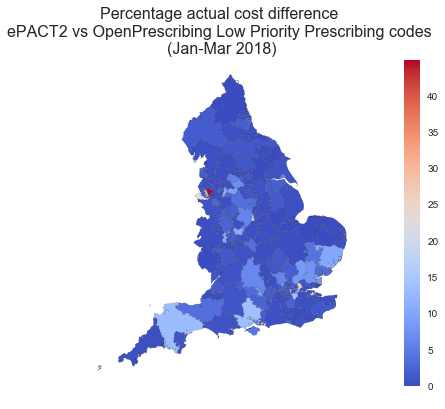

In [45]:
import geopandas as gpd
from matplotlib import verbose
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf= ccgs.join(map_data)


# set sort order of measures manually, and add grid refs to position each subplot:
s_map = [(0,'actual_cost_epact',0,0)]

# set common value limits for colour scale
vmin, vmax = 0, gdf['actual_cost_epact'].max()

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1,1)  # grid layout for subplots

for i in s_map:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title('Percentage actual cost difference \nePACT2 vs OpenPrescribing Low Priority Prescribing codes \n(Jan-Mar 2018)', size=16)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
#plt.savefig('Figure 3.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

In [19]:
gdf.head()

,ons_code,org_type,geometry,pct_op,items_epact,code
name,,,,,,
"NHS HAMBLETON, RICHMONDSHIRE AND WHITBY CCG",None,CCG,POLYGON ((-0.774157240450149 54.55326363508182...,03D,-0.034729,03D
NHS MID ESSEX CCG,None,CCG,(POLYGON ((0.688292873734376 52.08473200653647...,06Q,-0.083993,06Q
NHS WEST HAMPSHIRE CCG,None,CCG,(POLYGON ((-1.498730774700315 51.3295825547969...,11A,-0.303047,11A
NHS GLOUCESTERSHIRE CCG,None,CCG,POLYGON ((-1.767657749722576 52.11255510758448...,11M,-0.017257,11M
NHS KERNOW CCG,None,CCG,(POLYGON ((-4.456125889190043 50.9288125149219...,11N,-0.019315,11N


In [23]:
print(ccg_data_df['items_epact'].min())

-0.75
